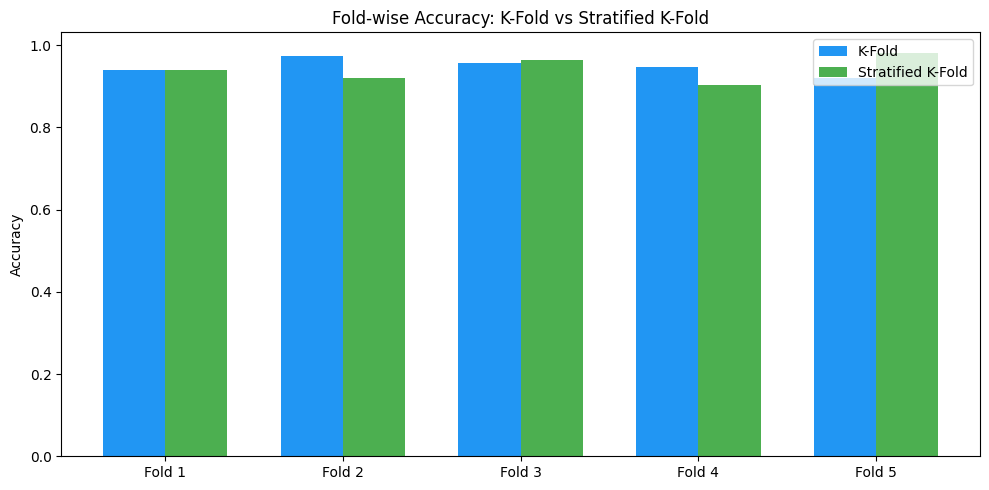

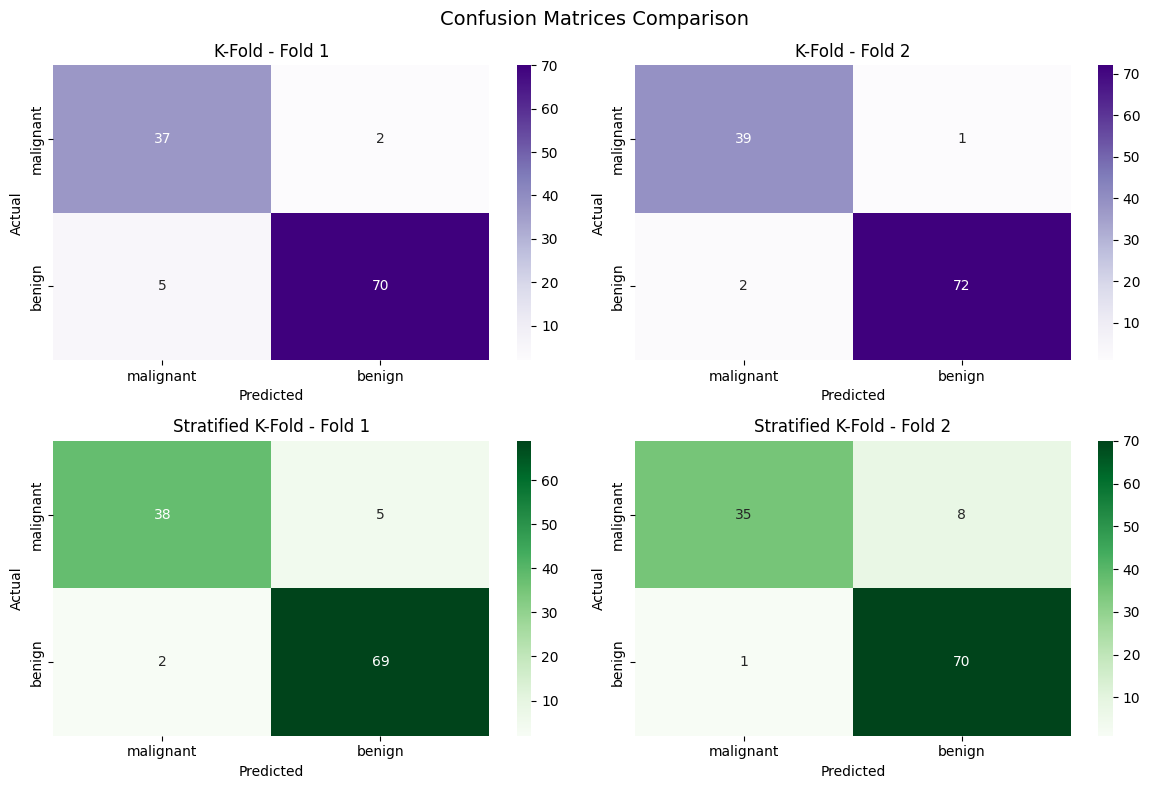

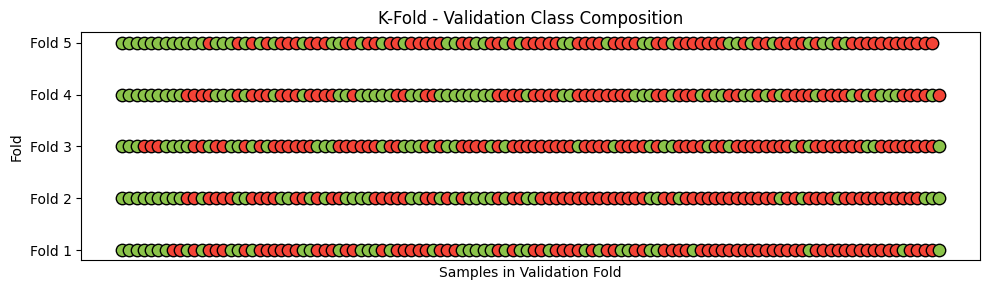

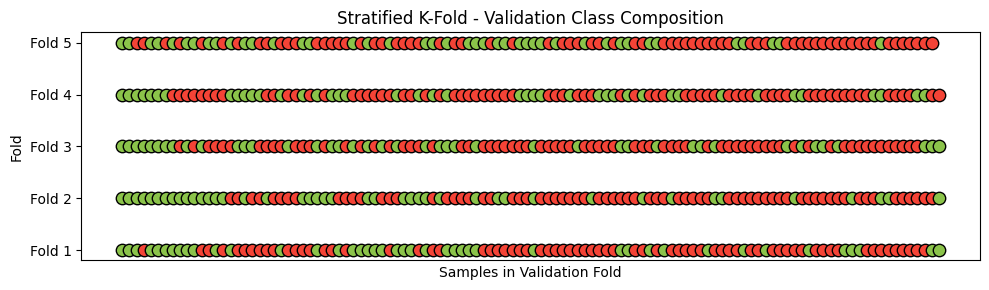

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# Load dataset
cancer_dataset = load_breast_cancer()
feature_data = cancer_dataset.data
target_labels = cancer_dataset.target
label_names = cancer_dataset.target_names

# Define classifier
logistic_clf = LogisticRegression(max_iter=1000, solver='liblinear')

# Cross-validation schemes
fold_splitter_standard = KFold(n_splits=5, shuffle=True, random_state=10)
fold_splitter_stratified = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

# Storage containers for results
performance_metrics = {
    'Standard': {'accuracy': [], 'precision': [], 'recall': [], 'conf_matrices': [], 'val_labels': []},
    'Stratified': {'accuracy': [], 'precision': [], 'recall': [], 'conf_matrices': [], 'val_labels': []}
}

# Evaluation loop
def evaluate_strategy(splitter, key_label):
    for train_indices, test_indices in splitter.split(feature_data, target_labels):
        X_train, X_test = feature_data[train_indices], feature_data[test_indices]
        y_train, y_test = target_labels[train_indices], target_labels[test_indices]

        logistic_clf.fit(X_train, y_train)
        predictions = logistic_clf.predict(X_test)

        performance_metrics[key_label]['accuracy'].append(accuracy_score(y_test, predictions))
        performance_metrics[key_label]['precision'].append(precision_score(y_test, predictions))
        performance_metrics[key_label]['recall'].append(recall_score(y_test, predictions))
        performance_metrics[key_label]['conf_matrices'].append(confusion_matrix(y_test, predictions))
        performance_metrics[key_label]['val_labels'].append(y_test)

# Run evaluations
evaluate_strategy(fold_splitter_standard, 'Standard')
evaluate_strategy(fold_splitter_stratified, 'Stratified')

# Accuracy bar chart
fold_names = [f"Fold {i+1}" for i in range(5)]
x_axis = np.arange(5)
bar_width = 0.35

plt.figure(figsize=(10, 5))
plt.bar(
    x_axis - bar_width / 2,
    performance_metrics['Standard']['accuracy'],
    width=bar_width,
    color="#2196F3",
    label="K-Fold"
)
plt.bar(
    x_axis + bar_width / 2,
    performance_metrics['Stratified']['accuracy'],
    width=bar_width,
    color="#4CAF50",
    label="Stratified K-Fold"
)

plt.title("Fold-wise Accuracy: K-Fold vs Stratified K-Fold")
plt.xticks(x_axis, fold_names)
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

# Confusion matrix plots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
methods = ['Standard', 'Stratified']
titles = ['K-Fold', 'Stratified K-Fold']
color_maps = ['Purples', 'Greens']

for row_idx, method in enumerate(methods):
    for col_idx in range(2):
        matrix = performance_metrics[method]['conf_matrices'][col_idx]
        sns.heatmap(
            matrix,
            annot=True,
            fmt='d',
            cmap=color_maps[row_idx],
            xticklabels=label_names,
            yticklabels=label_names,
            ax=axes[row_idx][col_idx]
        )
        axes[row_idx][col_idx].set_title(f"{titles[row_idx]} - Fold {col_idx+1}")
        axes[row_idx][col_idx].set_xlabel("Predicted")
        axes[row_idx][col_idx].set_ylabel("Actual")

fig.suptitle("Confusion Matrices Comparison", fontsize=14)
plt.tight_layout()
plt.show()

# Dot-style class composition plot per fold
def dot_visualization(val_label_lists, method_name, dot_color):
    plt.figure(figsize=(10, 3))
    for fold_index, labels in enumerate(val_label_lists):
        for i, label in enumerate(labels):
            color = dot_color[label]
            plt.scatter(i, fold_index, c=color, edgecolor='black', s=80)
    plt.yticks(range(5), [f"Fold {i+1}" for i in range(5)])
    plt.xticks([])
    plt.title(f"{method_name} - Validation Class Composition")
    plt.xlabel("Samples in Validation Fold")
    plt.ylabel("Fold")
    plt.tight_layout()
    plt.show()

dot_visualization(performance_metrics['Standard']['val_labels'], "K-Fold", {0: "#8BC34A", 1: "#F44336"})
dot_visualization(performance_metrics['Stratified']['val_labels'], "Stratified K-Fold", {0: "#8BC34A", 1: "#F44336"})
